# Food Demand Forecast

Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

Historical data of demand for a product-center combination (Weeks: 1 to 145)
Product(Meal) features such as category, sub-category, current price and discount
Information for fulfillment center like center area, city information etc.
 

**Data Dictionary**
1.	Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable 

Variable|Definition
:-------|:---------
id      | Unique ID
week	| Week No
center_id|Unique ID for fulfillment center
meal_id	  | Unique ID for Meal
checkout_price|Final price including discount, taxes & delivery charges
base_price	   | Base price of the meal
emailer_for_promotion|	Emailer sent for promotion of meal
homepage_featured	  |  Meal featured at homepage
num_orders	           | (Target) Orders Count

2.	fulfilment_center_info.csv: Contains information for each fulfilment center

Variable	|    Definition
:---------|:---------
center_id	|    Unique ID for fulfillment center
city_code	 |   Unique code for city
region_code	  |  Unique code for region
center_type	  |  Anonymized center type
op_area	      |  Area of operation (in km^2)
 
3.	meal_info.csv: Contains information for each meal being served

Variable	|    Definition
:---------|:---------
meal_id	  |      Unique ID for the meal
category	|    Type of meal (beverages/snacks/soups….)
cuisine	    |    Meal cuisine (Indian/Italian/…)



In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

In [38]:
# loading the datasets
weekly_demand = pd.read_csv('D:/Projects/End-to-End Food Demand Forecasting/notebook/data/train.csv')
fullfil_centers = pd.read_csv('D:/Projects/End-to-End Food Demand Forecasting/notebook/data/fulfilment_center_info.csv')
meal_info = pd.read_csv('D:/Projects/End-to-End Food Demand Forecasting/notebook/data/meal_info.csv')
test = pd.read_csv('D:/Projects/End-to-End Food Demand Forecasting/notebook/data/test.csv')

In [39]:
# Displaying the first few rows of the weekly demand dataset to understand its structure
weekly_demand.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [40]:
# Checking the data types and non-null counts in the weekly demand dataset
weekly_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [41]:
# Generating summary statistics for numerical columns in the weekly demand dataset
weekly_demand.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,456548.0,1.250096e+06,144354.822378,1000000.00,1124998.75,1250183.50,1375140.25,1499999.00
week,456548.0,7.476877e+01,41.524956,1.00,39.00,76.00,111.00,145.00
center_id,456548.0,8.210580e+01,45.975046,10.00,43.00,76.00,110.00,186.00
meal_id,456548.0,2.024337e+03,547.420920,1062.00,1558.00,1993.00,2539.00,2956.00
checkout_price,456548.0,3.322389e+02,152.939723,2.97,228.95,296.82,445.23,866.27
base_price,456548.0,3.541566e+02,160.715914,55.35,243.50,310.46,458.87,866.27
emailer_for_promotion,456548.0,8.115247e-02,0.273069,0.00,0.00,0.00,0.00,1.00
homepage_featured,456548.0,1.091999e-01,0.311890,0.00,0.00,0.00,0.00,1.00
num_orders,456548.0,2.618728e+02,395.922798,13.00,54.00,136.00,324.00,24299.00


In [42]:
# checking for null values in weekly demand dataset
weekly_demand.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [43]:
fullfil_centers.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [44]:
# Checking the data types and non-null counts in the fulfillment centers dataset
fullfil_centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [45]:
# Generating summary statistics for numerical columns in the weekly demand dataset
fullfil_centers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
center_id,77.0,83.142857,46.090219,10.0,50.0,77.0,110.0,186.0
city_code,77.0,600.662338,66.720274,456.0,553.0,596.0,651.0,713.0
region_code,77.0,56.493506,18.126473,23.0,34.0,56.0,77.0,93.0
op_area,77.0,3.985714,1.106406,0.9,3.5,3.9,4.4,7.0


In [46]:
# Checking for missing values in the fullfilment canter dataset
fullfil_centers.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [47]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [48]:
# Checking the data types and non-null counts in the meal info dataset
meal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [49]:
# checking for null values in meal info dataset
meal_info.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

In [50]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32573 non-null  int64  
 1   week                   32573 non-null  int64  
 2   center_id              32573 non-null  int64  
 3   meal_id                32573 non-null  int64  
 4   checkout_price         32573 non-null  float64
 5   base_price             32573 non-null  float64
 6   emailer_for_promotion  32573 non-null  int64  
 7   homepage_featured      32573 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


In [52]:
# Generating summary statistics for numerical columns in the test dataset
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,32573.0,1.248476e+06,144158.048324,1000085.00,1123969.00,1247296.00,1372971.00,1499996.00
week,32573.0,1.504778e+02,2.864072,146.00,148.00,150.00,153.00,155.00
center_id,32573.0,8.190173e+01,45.950455,10.00,43.00,76.00,110.00,186.00
meal_id,32573.0,2.032068e+03,547.199004,1062.00,1558.00,1993.00,2569.00,2956.00
checkout_price,32573.0,3.418544e+02,153.893886,67.90,214.43,320.13,446.23,1113.62
base_price,32573.0,3.564936e+02,155.150101,89.24,243.50,321.13,455.93,1112.62
emailer_for_promotion,32573.0,6.643539e-02,0.249045,0.00,0.00,0.00,0.00,1.00
homepage_featured,32573.0,8.135572e-02,0.273385,0.00,0.00,0.00,0.00,1.00


In [53]:
# checking for null values in test dataset
test.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

In [54]:
# Adding a placeholder column for predictions in the test dataset
test['num_orders'] = 0

In [55]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1028232,146,55,1885,158.11,159.11,0,0,0
1,1127204,146,55,1993,160.11,159.11,0,0,0
2,1212707,146,55,2539,157.14,159.14,0,0,0
3,1082698,146,55,2631,162.02,162.02,0,0,0
4,1400926,146,55,1248,163.93,163.93,0,0,0


In [56]:
# merging all the data sets into single datset for analysis
data = pd.concat([weekly_demand, test], axis=0)
data = data.merge(fullfil_centers, on='center_id', how='left')
data = data.merge(meal_info, on='meal_id', how='left')
data.shape

(489121, 15)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489121 entries, 0 to 489120
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     489121 non-null  int64  
 1   week                   489121 non-null  int64  
 2   center_id              489121 non-null  int64  
 3   meal_id                489121 non-null  int64  
 4   checkout_price         489121 non-null  float64
 5   base_price             489121 non-null  float64
 6   emailer_for_promotion  489121 non-null  int64  
 7   homepage_featured      489121 non-null  int64  
 8   num_orders             489121 non-null  int64  
 9   city_code              489121 non-null  int64  
 10  region_code            489121 non-null  int64  
 11  center_type            489121 non-null  object 
 12  op_area                489121 non-null  float64
 13  category               489121 non-null  object 
 14  cuisine                489121 non-nu

In [58]:
data.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

The null values in num_order column are equal to the number of rows in the test dataset (containing data from week 146-155) loaded earlier. These rows will be left out of the analysis since we want to predict the demand for the next 10-week period with the help of a prediction model.

# Feature Engineering


In [59]:
# Creating a new feature for discount amount
data['discount_amount'] = round(data['base_price']-data['checkout_price'],4)

In [60]:
# Creating a new feature for discount percentage
data['discount_percent'] = round(((data['base_price']-data['checkout_price'])/data['base_price'])*100,4)

In [61]:
# Creating a binary feature to indicate whether a discount was applied
data['discount y/n'] = [1 if x>0 else 0 for x in (data['base_price']-data['checkout_price'])]

In [62]:
# Creating a feature to compare the change in weekly prices
data['weekly_base_price_change'] = round(data.groupby(['meal_id', 'center_id'])['base_price'].diff(),4)

# Fill NaN values (e.g., for the first week) with 0
data['weekly_base_price_change'] = data['weekly_base_price_change'].fillna(0)

In [63]:
# Creating feature that calculates weekly changes in checkout price
data['weekly_checkout_price_change'] = round(data.groupby(['meal_id', 'center_id'])['checkout_price'].diff(),4)

# Fill NaN values (e.g., for the first week) with 0
data['weekly_checkout_price_change'] = data['weekly_checkout_price_change'].fillna(0)

In [64]:
# Extract week of the year
data['week_of_year'] = data['week'].apply(lambda x: x % 52 if x % 52 != 0 else 52)

In [65]:
# Extract quarter of the year
data['quarter'] = data['week_of_year'].apply(lambda x: (x - 1) // 13 + 1)

In [66]:
data['month'] = data['week_of_year'].apply(lambda x: (x-1) // 4 + 1)

In [67]:
# Counting the number of occurrences of each quarter
data['quarter'].value_counts()

quarter
3    124373
2    122513
4    121634
1    120601
Name: count, dtype: int64

In [68]:
# Calculating 4-week rolling average for checkout_price and base_price
data['4_week_avg_checkout_price'] = round(data.groupby(['meal_id', 'center_id'])['checkout_price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean()),4)
data['4_week_avg_base_price'] = round(data.groupby(['meal_id', 'center_id'])['base_price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean()),4)

In [69]:
data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount_amount', 'discount_percent', 'discount y/n',
       'weekly_base_price_change', 'weekly_checkout_price_change',
       'week_of_year', 'quarter', 'month', '4_week_avg_checkout_price',
       '4_week_avg_base_price'],
      dtype='object')

In [70]:
#Creating lag feature
data = data.sort_values(['meal_id','center_id','week'])
for lag in [1,2,3,4,10]:
    data[f'lag_{lag}'] = data.groupby(['meal_id','center_id'])['num_orders'].shift(lag).fillna(0)

rolling_window = data.groupby(['meal_id','center_id'])['num_orders'].shift(1).rolling(window=4, min_periods=1)

data['rolling_4_week_mean'] = round(rolling_window.mean().fillna(0),2)


# Calculate the average checkout price for each category in each week

avg_price_cat = data.groupby(['week','category'])['base_price'].apply(lambda x: x.mean()).reindex(data.set_index(['week', 'category']).index).values

data['price_vs_category_avg'] = round(data['base_price'] - avg_price_cat,2)


In [71]:
data['emailer_for_promotion'] = data['emailer_for_promotion'].astype('object')
data['homepage_featured'] = data['homepage_featured'].astype('object')
data['center_id'] = data['center_id'].astype('object')
data['meal_id'] = data['meal_id'].astype('object')


In [72]:
data['base_price_max'] = data.groupby('meal_id')['base_price'].transform('max')
data['base_price_min'] = data.groupby('meal_id')['base_price'].transform('min')
data['base_price_mean'] = round(data.groupby('meal_id')['base_price'].transform('mean'),4)
data['meal_price_max'] = data.groupby('meal_id')['checkout_price'].transform('max')
data['meal_price_min'] = data.groupby('meal_id')['checkout_price'].transform('min')
data['meal_price_mean'] = round(data.groupby('meal_id')['checkout_price'].transform('mean'),4)

In [73]:
data['center_cat_count'] = data.groupby(['category','center_id'])['num_orders'].transform('count')

In [74]:
data.isnull().sum()

id                              0
week                            0
center_id                       0
meal_id                         0
checkout_price                  0
base_price                      0
emailer_for_promotion           0
homepage_featured               0
num_orders                      0
city_code                       0
region_code                     0
center_type                     0
op_area                         0
category                        0
cuisine                         0
discount_amount                 0
discount_percent                0
discount y/n                    0
weekly_base_price_change        0
weekly_checkout_price_change    0
week_of_year                    0
quarter                         0
month                           0
4_week_avg_checkout_price       0
4_week_avg_base_price           0
lag_1                           0
lag_2                           0
lag_3                           0
lag_4                           0
lag_10        

In [37]:
data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount_amount', 'discount_percent', 'discount y/n',
       'weekly_base_price_change', 'weekly_checkout_price_change',
       'week_of_year', 'quarter', 'month', '4_week_avg_checkout_price',
       '4_week_avg_base_price', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_10',
       'rolling_4_week_mean', 'price_vs_category_avg'],
      dtype='object')

In [38]:
data.shape

(489121, 32)

In [40]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,489121.0,1.249988e+06,144342.144768,1000000.00,1124937.00,1249977.00,1374988.00,1499999.00
week,489121.0,7.981061e+01,44.343325,1.00,42.00,81.00,118.00,155.00
checkout_price,489121.0,3.328793e+02,153.022073,2.97,228.01,299.76,445.23,1113.62
base_price,489121.0,3.543123e+02,160.352168,55.35,243.50,311.43,458.81,1112.62
num_orders,489121.0,2.444334e+02,388.044503,0.00,41.00,122.00,298.00,24299.00
city_code,489121.0,6.015512e+02,66.182598,456.00,553.00,596.00,651.00,713.00
region_code,489121.0,5.662107e+01,17.641296,23.00,34.00,56.00,77.00,93.00
op_area,489121.0,4.083865e+00,1.092163,0.90,3.60,4.00,4.50,7.00
discount_amount,489121.0,2.143298e+01,47.976701,-185.30,-1.00,0.03,5.85,820.59
discount_percent,489121.0,5.628928e+00,11.309374,-72.79,-0.15,0.02,2.60,99.06


In [41]:
data.info(0)

<class 'pandas.core.frame.DataFrame'>
Index: 489121 entries, 2370 to 358495
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            489121 non-null  int64  
 1   week                          489121 non-null  int64  
 2   center_id                     489121 non-null  object 
 3   meal_id                       489121 non-null  object 
 4   checkout_price                489121 non-null  float64
 5   base_price                    489121 non-null  float64
 6   emailer_for_promotion         489121 non-null  object 
 7   homepage_featured             489121 non-null  object 
 8   num_orders                    489121 non-null  int64  
 9   city_code                     489121 non-null  int64  
 10  region_code                   489121 non-null  int64  
 11  center_type                   489121 non-null  object 
 12  op_area                       489121 non-null 

In [42]:
data.isnull().sum()

id                              0
week                            0
center_id                       0
meal_id                         0
checkout_price                  0
base_price                      0
emailer_for_promotion           0
homepage_featured               0
num_orders                      0
city_code                       0
region_code                     0
center_type                     0
op_area                         0
category                        0
cuisine                         0
discount_amount                 0
discount_percent                0
discount y/n                    0
weekly_base_price_change        0
weekly_checkout_price_change    0
week_of_year                    0
quarter                         0
month                           0
4_week_avg_checkout_price       0
4_week_avg_base_price           0
lag_1                           0
lag_2                           0
lag_3                           0
lag_4                           0
lag_10        

In [43]:
# Filtering the dataset to include only data from weeks 1 to 145 for further analysis
datax = data[data['week'].isin(range(1,146))]

In [44]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456548 entries, 2370 to 358495
Data columns (total 32 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id                            456548 non-null  int64  
 1   week                          456548 non-null  int64  
 2   center_id                     456548 non-null  object 
 3   meal_id                       456548 non-null  object 
 4   checkout_price                456548 non-null  float64
 5   base_price                    456548 non-null  float64
 6   emailer_for_promotion         456548 non-null  object 
 7   homepage_featured             456548 non-null  object 
 8   num_orders                    456548 non-null  int64  
 9   city_code                     456548 non-null  int64  
 10  region_code                   456548 non-null  int64  
 11  center_type                   456548 non-null  object 
 12  op_area                       456548 non-null 

Using data from week 1 to week 145 for further analysis.

# Exploratory Data Analysis (EDA)

<Axes: >

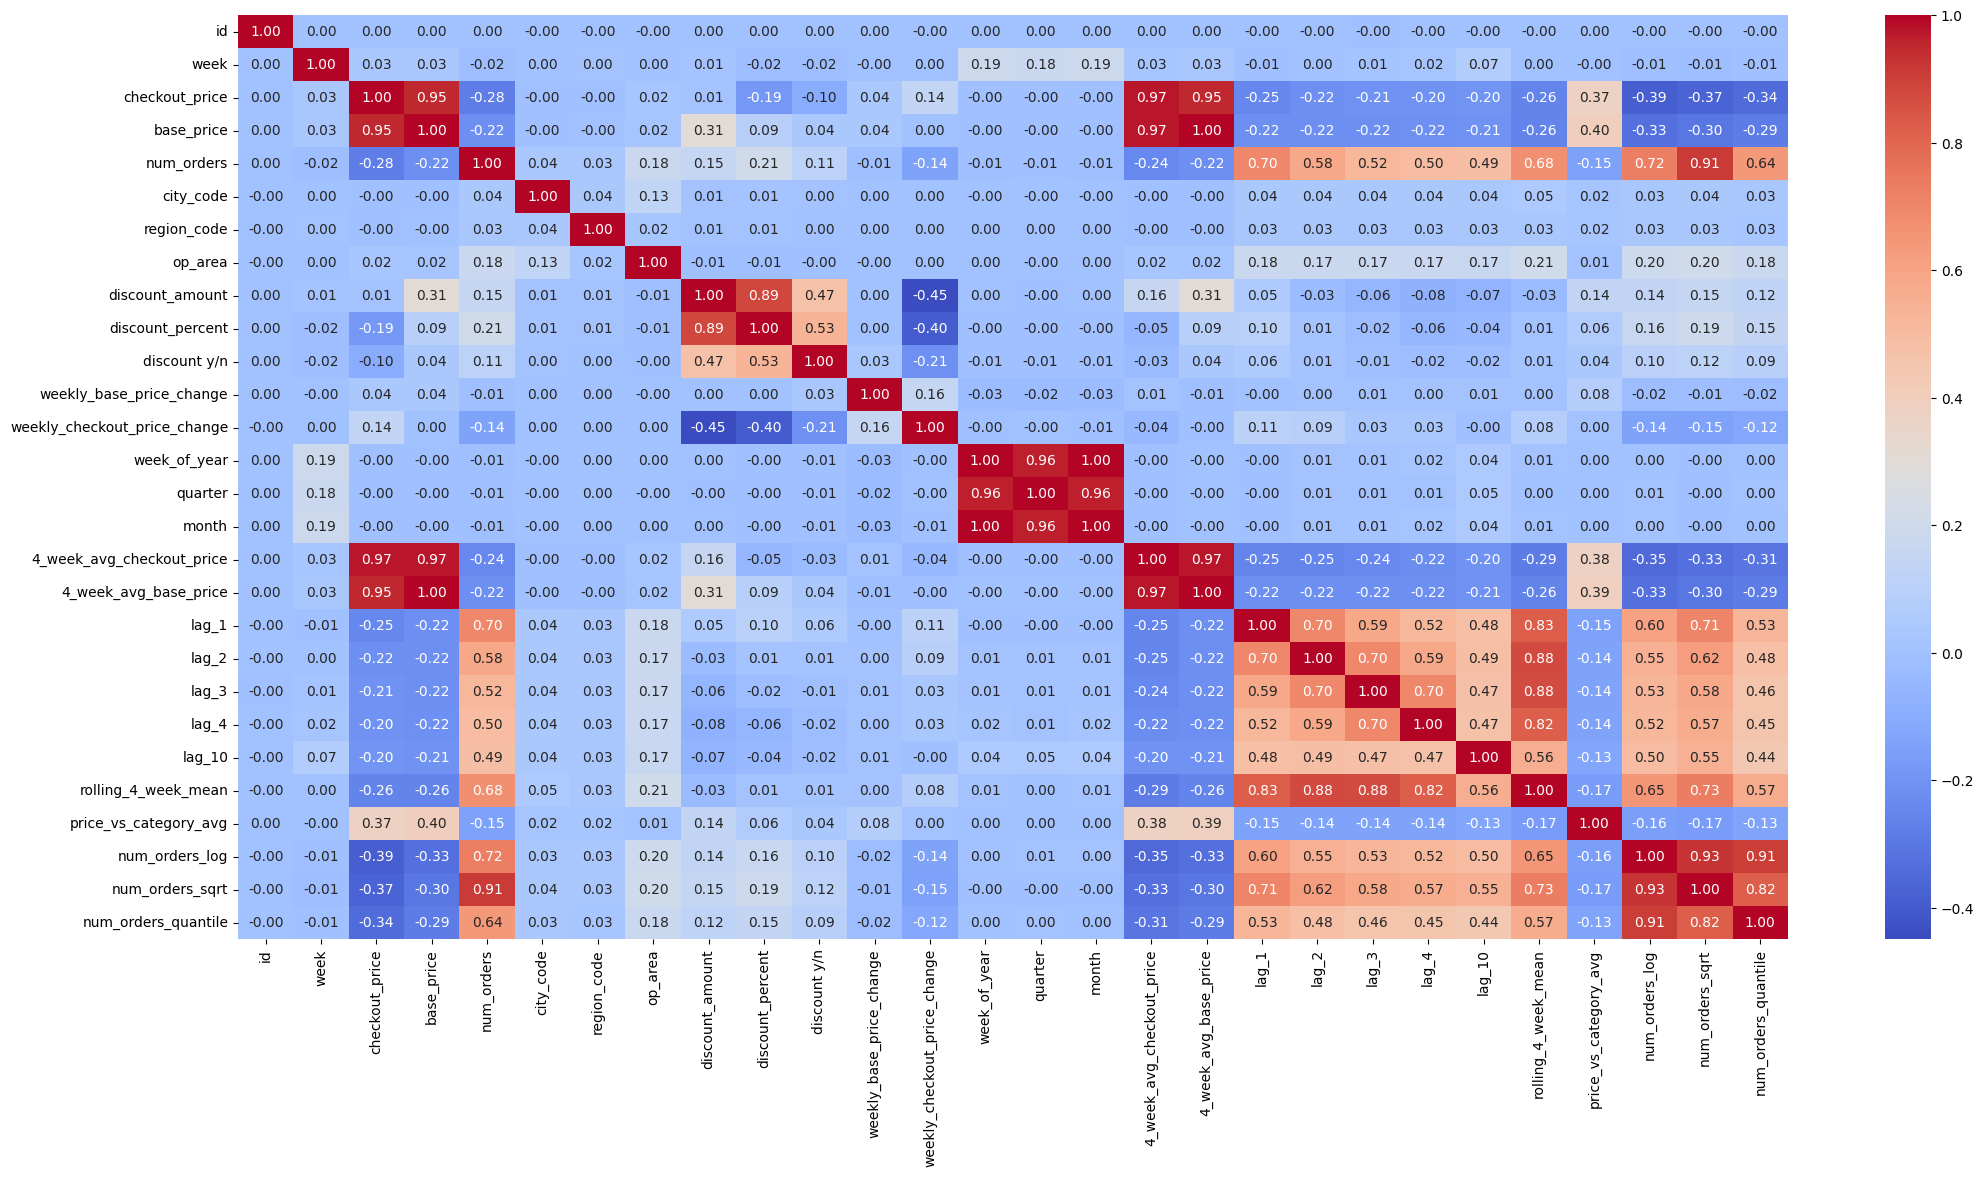

In [58]:
# Visualizing correlations between numerical features using a heatmap
plt.figure(figsize=(25, 12))
sns.heatmap(datax.corr(numeric_only=True), annot=True, cmap='coolwarm',fmt=".2f")

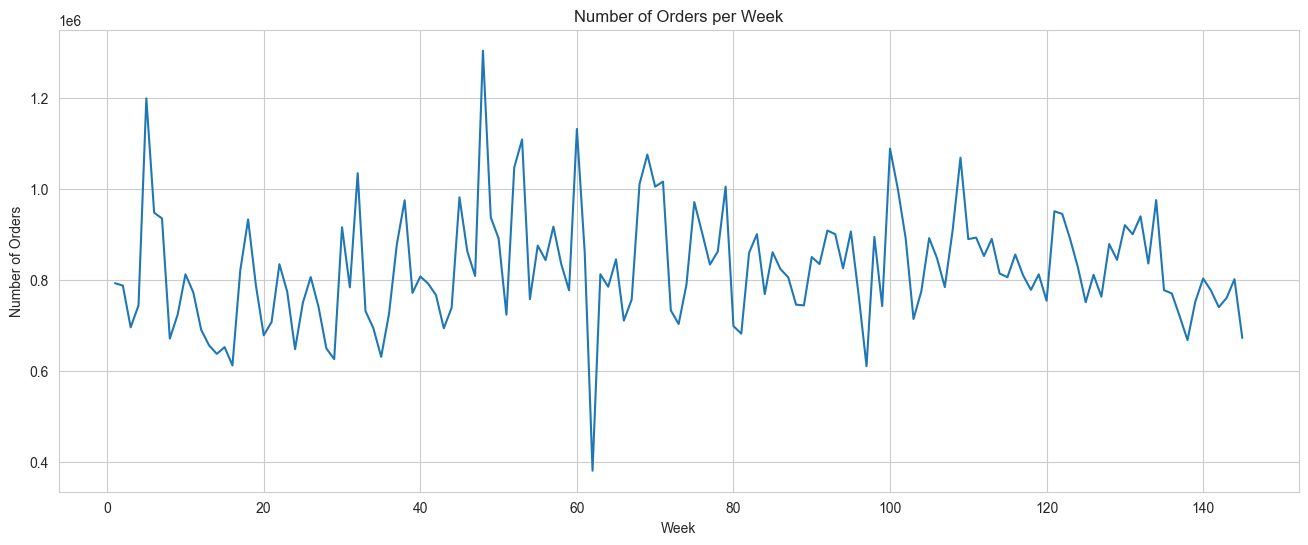

In [59]:
# Visualizing the trend of the number of orders per week
sns.set_style('whitegrid')
plt.figure(figsize=(16, 6))
sns.lineplot(x='week', y='num_orders', data=datax,estimator='sum',errorbar=None)
plt.title('Number of Orders per Week')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.show()

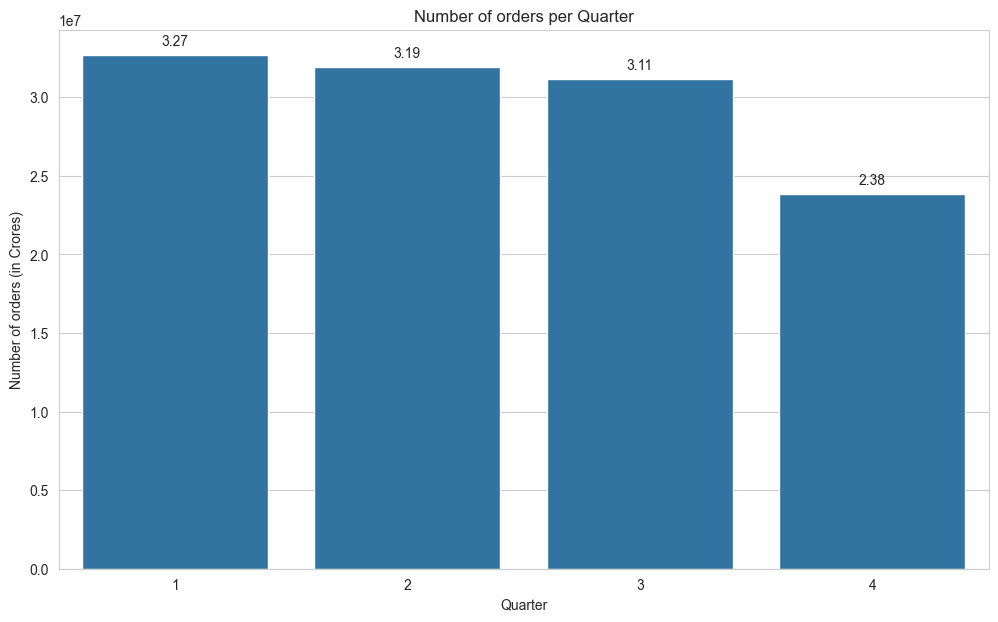

In [60]:
# Visualizing the trend of the number of orders per quarter
plt.figure(figsize=(12, 7))
a1 = sns.barplot(x='quarter', y='num_orders', data=datax, estimator='sum', errorbar=None)
plt.ylabel('Number of orders (in Crores)')
plt.xlabel('Quarter')
plt.title('Number of orders per Quarter')

# display data labels on bars
for p in a1.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a1.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    
plt.show()


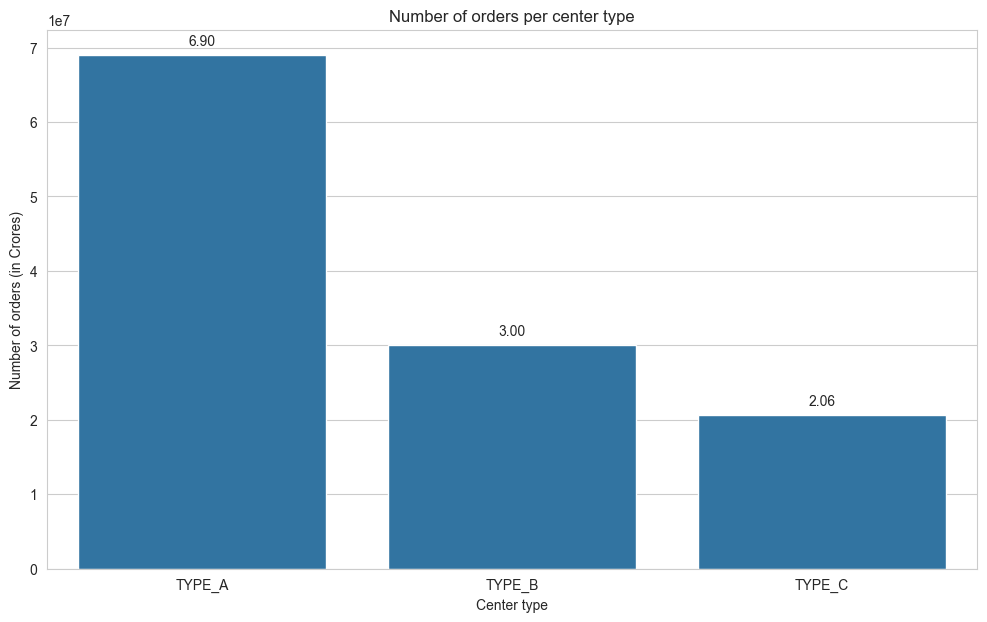

In [61]:
# Display total number of orders for each Center type
plt.figure(figsize=(12, 7))
a1 = sns.barplot(x='center_type', y='num_orders', data=datax.groupby('center_type').num_orders.sum().sort_values(ascending=False).reset_index(),
                 errorbar=None)
plt.ylabel('Number of orders (in Crores)')
plt.xlabel('Center type')
plt.title('Number of orders per center type')

# display data labels on bars
for p in a1.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a1.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    
plt.show()


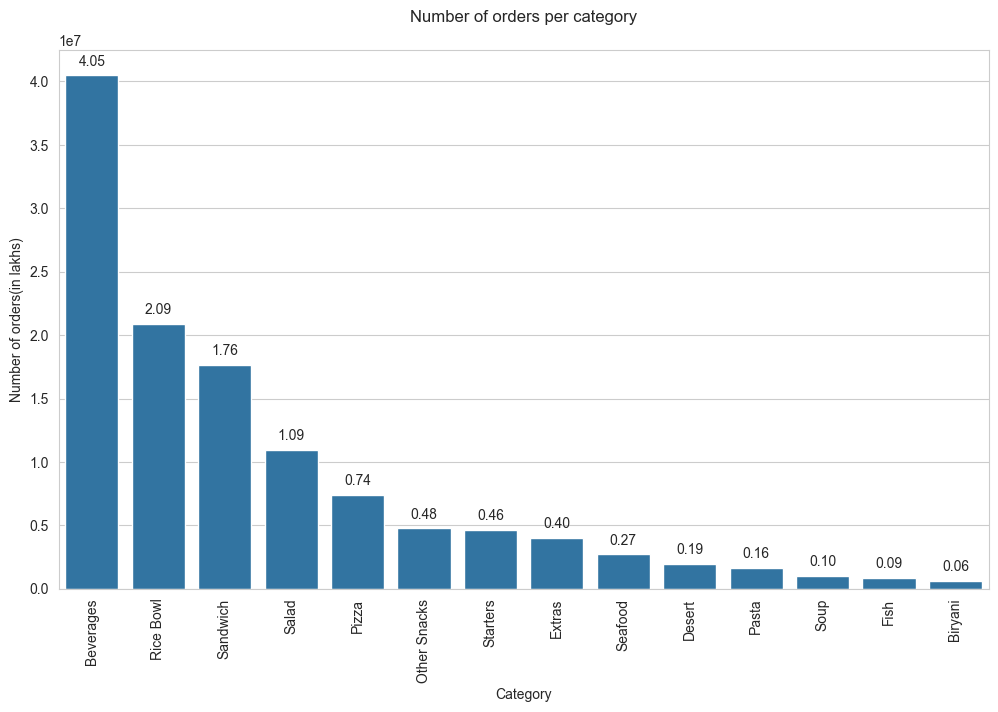

In [62]:
# Display total number of orders for each meal category
sns.set_style('whitegrid')
plt.figure(figsize=(12, 7))
a2 = sns.barplot(x='category', y='num_orders', data=datax.groupby('category').num_orders.sum().sort_values(ascending=False).reset_index(),
                 errorbar=None)
plt.ylabel('Number of orders(in lakhs)')
plt.xlabel('Category')
plt.title('Number of orders per category',pad=20)
plt.xticks(rotation=90)

# display data labels on bars
for p in a2.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a2.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()

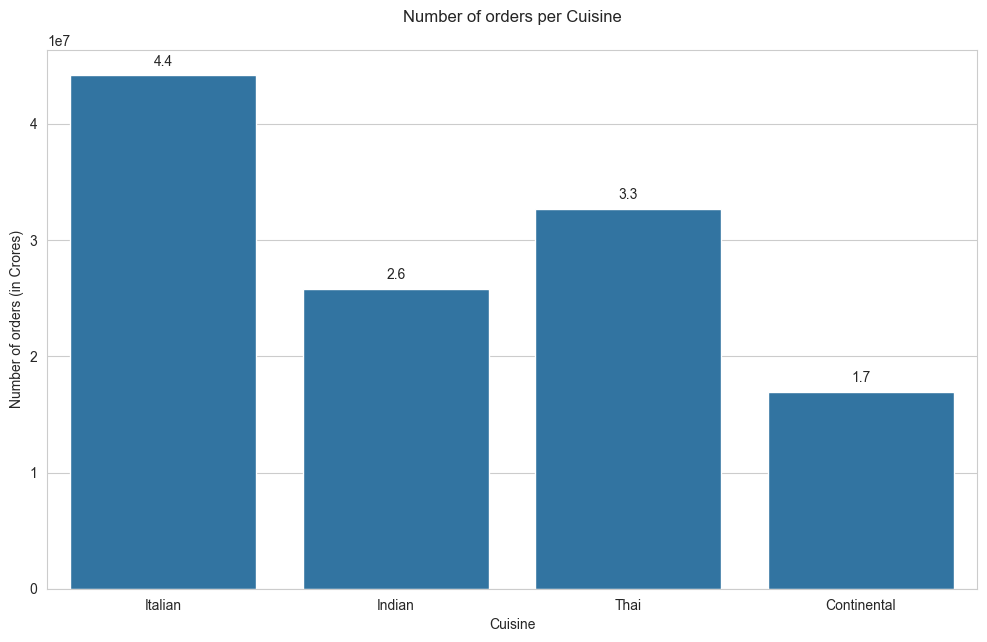

In [63]:
# Visualizing the total number of orders for each cuisine type    
sns.set_style('whitegrid')
plt.figure(figsize=(12, 7))  # Adjust the width and height as needed
a3 = sns.barplot(x='cuisine', y='num_orders', data=datax,estimator=sum,errorbar=None)
plt.ylabel('Number of orders (in Crores)')
plt.xlabel('Cuisine')
plt.title('Number of orders per Cuisine', pad=20)

# Display data labels on bars
for p in a3.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a3.annotate(format(value_in_crores, '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# plt.xticks(rotation=90)
# plt.show()

Text(0.5, 1.0, 'Total Number of Orders for Each Category')

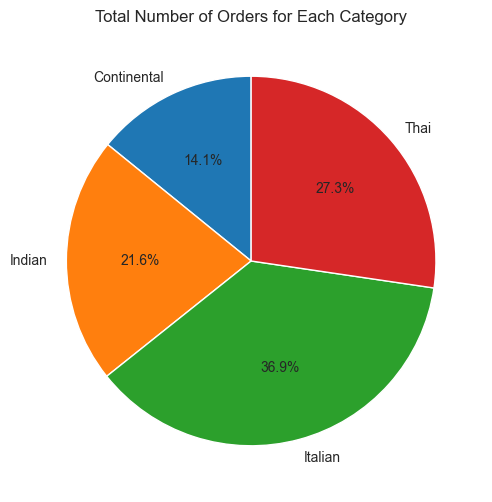

In [64]:
# A pie chart to visualize the total number of orders for each cuisine type.
plt.figure(figsize=(6,6))
plt.pie(datax.groupby(['cuisine']).num_orders.sum(),
    labels=datax.groupby(['cuisine']).num_orders.sum().index,
    startangle=90,
    autopct='%1.1f%%',pctdistance=0.6,)
plt.title('Total Number of Orders for Each Category')

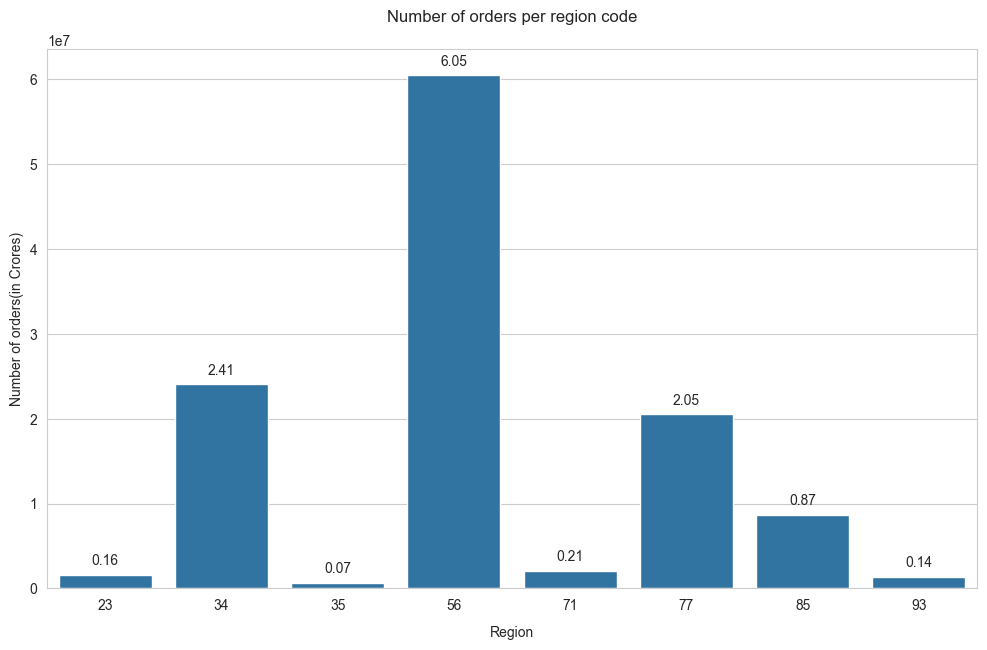

In [65]:
# Display total number of orders for each region code.
plt.figure(figsize=(12, 7))
a4 = sns.barplot(x='region_code',y='num_orders',data=datax,estimator=sum,errorbar=None)
                 
plt.ylabel('Number of orders(in Crores)')
plt.xlabel('Region',labelpad=10)
plt.title('Number of orders per region code',pad=20)
for p in a4.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a4.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center', xytext = (0, 10),
                  textcoords = 'offset points')
plt.show()

Text(0.5, 0, 'City')

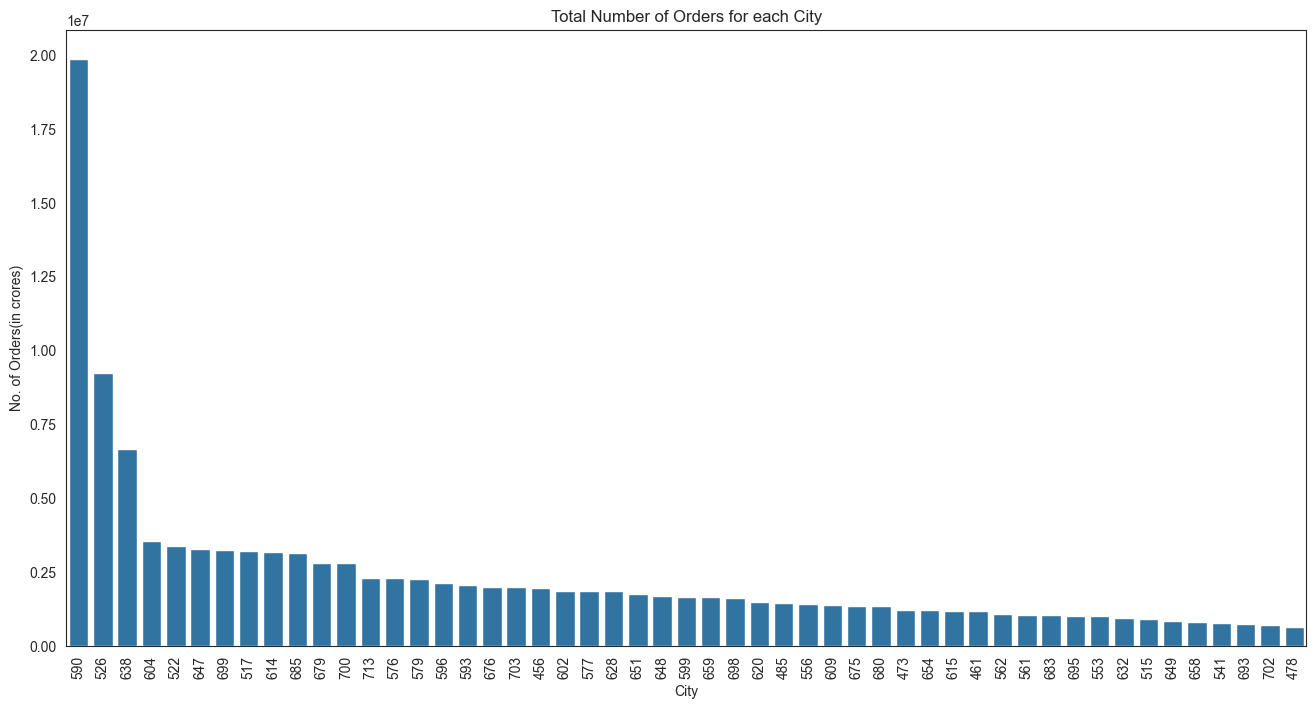

In [66]:
# Visualizing the trend of the number of orders for each city.
fig=plt.figure(figsize=(16,8))
sns.set_style("white")
plt.xticks(rotation=90)
plt.title('Total Number of Orders for each City')
a5 = sns.barplot(y='num_orders', x='city_code', data=datax.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index(),
            order=list(datax.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index()['city_code'].values))
plt.ylabel('No. of Orders(in crores)')
plt.xlabel('City')

As per our observation from our barchart of the City against the number of orders. There the high significant difference between the Top 3 cities(590,526,638) which have the highest number of orders. Therefore, we will categorize the City with Highest No. of Orders as C1, City with 2nd Highest No. of Orders as C2 and City with 3rd Highest No. of Orders as C3 and the remaining cities will be categorized as CH4, since, they do not have much significant differences between the number of orders.

In [67]:
# Categorizing cities into four groups based on their order volume.
city4={590:'C1', 526:'C2', 638:'C3'}
data['city_cat']=data['city_code'].map(city4)
data['city_cat']=data['city_cat'].fillna('C4')

In [68]:
data['city_cat'].value_counts()

city_cat
C4    362341
C1     58708
C2     46589
C3     21483
Name: count, dtype: int64

In [69]:
from sklearn.preprocessing import OneHotEncoder

In [70]:
# # Select categorical columns
# categorical_columns = data.select_dtypes(include=['object']).columns
# categorical_columns

In [71]:
data['region_code'].value_counts()

region_code
56    204911
34    124978
77    101300
85     32521
23      6883
71      6761
93      6133
35      5634
Name: count, dtype: int64

In [72]:
# Split data into train and test before encoding
train_df = data[data['week'].isin(range(1,136))] #for training the model
test_df = data[data['week'].isin(range(136,146))] #for testing the model
last_10week_df = data[data['week'].isin(range(146,156))] # for predicitions

In [73]:
data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount_amount', 'discount_percent', 'discount y/n',
       'weekly_base_price_change', 'weekly_checkout_price_change',
       'week_of_year', 'quarter', 'month', '4_week_avg_checkout_price',
       '4_week_avg_base_price', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_10',
       'rolling_4_week_mean', 'price_vs_category_avg', 'city_cat'],
      dtype='object')

In [74]:
numerical_columns = ['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
                    'region_code', 'op_area', 'discount_amount',
                    'discount_percent', 'discount y/n', 'weekly_base_price_change',
                    'weekly_checkout_price_change', 'week_of_year', 'quarter', 'month',
                    '4_week_avg_checkout_price', '4_week_avg_base_price', 'lag_1', 'lag_2',
                    'lag_3', 'lag_4', 'rolling_4_week_mean', 'price_vs_category_avg']

categorical_columns = [ 'emailer_for_promotion', 'homepage_featured', 'center_type', 'category',
                        'cuisine', 'city_cat']

In [75]:
# numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
# categorical_columns = data.select_dtypes(include=['object']).columns
# categorical_columns

In [76]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [77]:
# Define the numerical and categorical transformers
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ],
    remainder='drop'  # This will drop any columns not specified in the transformers
)

In [78]:
# target_column = np.log1p(data['num_orders'])

In [79]:
# Prepare X_train, y_train, X_test, y_test
X_train = train_df.drop(columns=['num_orders'], axis=1).reset_index(drop=True) 
y_train = train_df['num_orders'].reset_index(drop=True)
X_test = test_df.drop(columns=['num_orders'], axis=1).reset_index(drop=True)
y_test = test_df['num_orders'].reset_index(drop=True)

# Display the updated DataFrames
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



X_train shape: (423727, 32)
X_test shape: (32821, 32)


In [80]:
X_train.columns


Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount_amount', 'discount_percent', 'discount y/n',
       'weekly_base_price_change', 'weekly_checkout_price_change',
       'week_of_year', 'quarter', 'month', '4_week_avg_checkout_price',
       '4_week_avg_base_price', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_10',
       'rolling_4_week_mean', 'price_vs_category_avg', 'city_cat'],
      dtype='object')

In [81]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [82]:
X_train_transformed.shape

SyntaxError: invalid syntax (912035406.py, line 1)

# Model 1 - Linear Regression

In [ ]:
# importing the libraries for model building
from sklearn.linear_model import LinearRegression

In [ ]:
# Initializing the Linear Regression model
lm = LinearRegression()

In [ ]:
# Fitting the model on the training data
lm.fit(X_train_transformed, y_train)

LinearRegression()

In [ ]:
# Predicting on the test data
lm_predictions = lm.predict(X_test_transformed)

In [ ]:
from sklearn import metrics

In [ ]:
# Evaluating the model performance.
mae = metrics.mean_absolute_error(y_test,lm_predictions)
mse = metrics.mean_squared_error(y_test, lm_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, lm_predictions))
r2 = metrics.r2_score(y_test, lm_predictions)
print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)


Mae: 91.05135812437159
Mse: 18371.02442533934
Rmse:  135.5397521959493
R2: 0.759868635592509


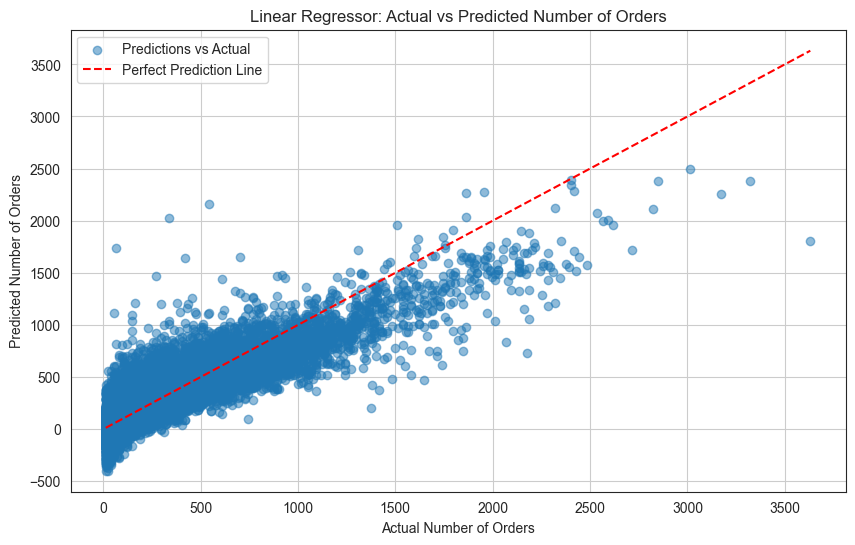

In [ ]:
# Plotting Linear Regressor predictions vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lm_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Linear Regressor: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 2: Ridge Regrssion

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

SyntaxError: invalid syntax (1416429806.py, line 2)

In [ ]:
# Initializing the Ridge Regression model
ridge = Ridge()
# Setting up the parameter grid for alpha values
param_grid = {'alpha': np.logspace(-5, 5, 50)}
# Performing Grid Search with Cross-Validation
ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
# Fitting the model on the training data
ridge_cv.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 1.59985872e-05, 2.55954792e-05, 4.09491506e-05,
       6.55128557e-05, 1.04811313e-04, 1.67683294e-04, 2.68269580e-04,
       4.29193426e-04, 6.86648845e-04, 1.09854114e-03, 1.75751062e-03,
       2.81176870e-03, 4.49843267e-03, 7.19685673e-03, 1.15139540e-02,
       1.84206997e-02, 2.94705170e-02, 4.71486636e-02, 7....
       5.17947468e+00, 8.28642773e+00, 1.32571137e+01, 2.12095089e+01,
       3.39322177e+01, 5.42867544e+01, 8.68511374e+01, 1.38949549e+02,
       2.22299648e+02, 3.55648031e+02, 5.68986603e+02, 9.10298178e+02,
       1.45634848e+03, 2.32995181e+03, 3.72759372e+03, 5.96362332e+03,
       9.54095476e+03, 1.52641797e+04, 2.44205309e+04, 3.90693994e+04,
       6.25055193e+04, 1.00000000e+05])},
             scoring='neg_mean_squared_error')

In [ ]:
# Making predicting with ridge regression on the test data
ridge_predictions = ridge_cv.predict(X_test_transformed)

In [ ]:
# Evaluating the model performance
mae = metrics.mean_absolute_error(y_test,ridge_predictions)
mse = metrics.mean_squared_error(y_test, ridge_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, ridge_predictions))
r2 = metrics.r2_score(y_test, ridge_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)

Mae: 89.8013005848888
Mse: 18122.634318577275
Rmse:  134.6203339714223
R2: 0.7631153927608151


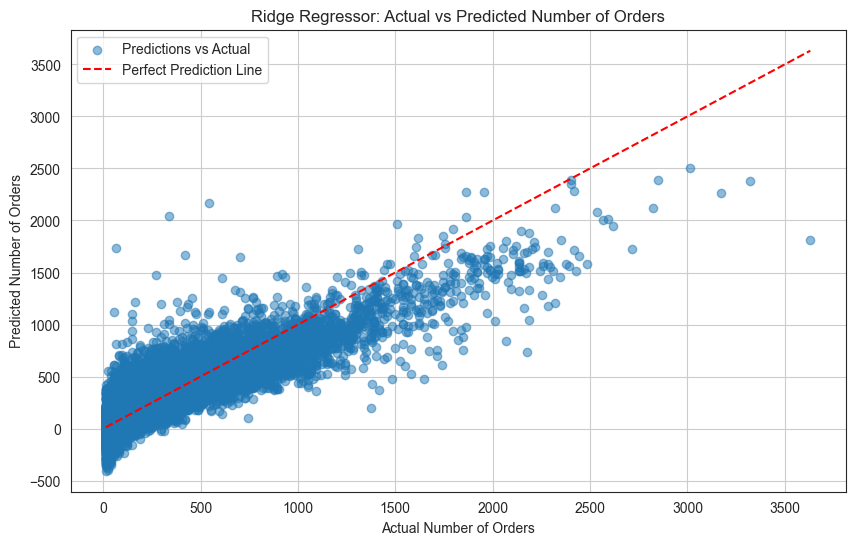

In [ ]:
# Plotting Ridge Regressor predictions vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ridge_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Ridge Regressor: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 3: Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
# # Initializing the Lasso Regression model
# lasso = Lasso()
# # Setting up the parameter grid for alpha values
# param_grid = {'alpha': np.logspace(-5, 3, 50)}
# # Performing Grid Search with Cross-Validation
# lasso_cv = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
# # Fitting the model on the training data
# lasso_cv.fit(X_train_transformed, y_train)

In [ ]:
# Making predictions with lasso regression on the test data
# lasso_predictions = lasso_cv.predict(X_test_transformed)

In [ ]:
# # Evaluating the model performance
# mae = metrics.mean_absolute_error(y_test,lasso_predictions)
# mse = metrics.mean_squared_error(y_test, lasso_predictions)
# rmse = np.sqrt(metrics.mean_squared_error(y_test, lasso_predictions))
# r2 = metrics.r2_score(y_test, lasso_predictions)

# print('Mae:',mae)
# print('Mse:', mse)
# print('Rmse: ',rmse)
# print('R2:', r2)

In [ ]:
# # Plotting Lasso Regressor predictions vs Actual values
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, lasso_predictions, alpha=0.5, label='Predictions vs Actual')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
# plt.xlabel('Actual Number of Orders')
# plt.ylabel('Predicted Number of Orders')
# plt.title('Lasso Regressor: Actual vs Predicted Number of Orders')
# plt.legend()
# plt.grid(True)
# plt.show()

# Model 3: Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Initializing the Decision tree Regressor model
dtree = DecisionTreeRegressor(max_depth=100,random_state=42)

In [ ]:
# Fitting the model on the training data
dtree.fit(X_train_transformed, y_train)

DecisionTreeRegressor(max_depth=100, random_state=42)

In [ ]:
# Making predictions with decision tree regressor on the test data
dtree_predictions = dtree.predict(X_test_transformed)

In [ ]:
# Evaluating the model performance
mae = metrics.mean_absolute_error(y_test,dtree_predictions)
mse = metrics.mean_squared_error(y_test, dtree_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, dtree_predictions))
r2 = metrics.r2_score(y_test, dtree_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, dtree_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)
print('Mape:', mape)

Mae: 107.69525608604248
Mse: 52376.24673227507
Rmse:  228.85857364817048
R2: 0.31537951835626676
Mape: 0.7414677272751946


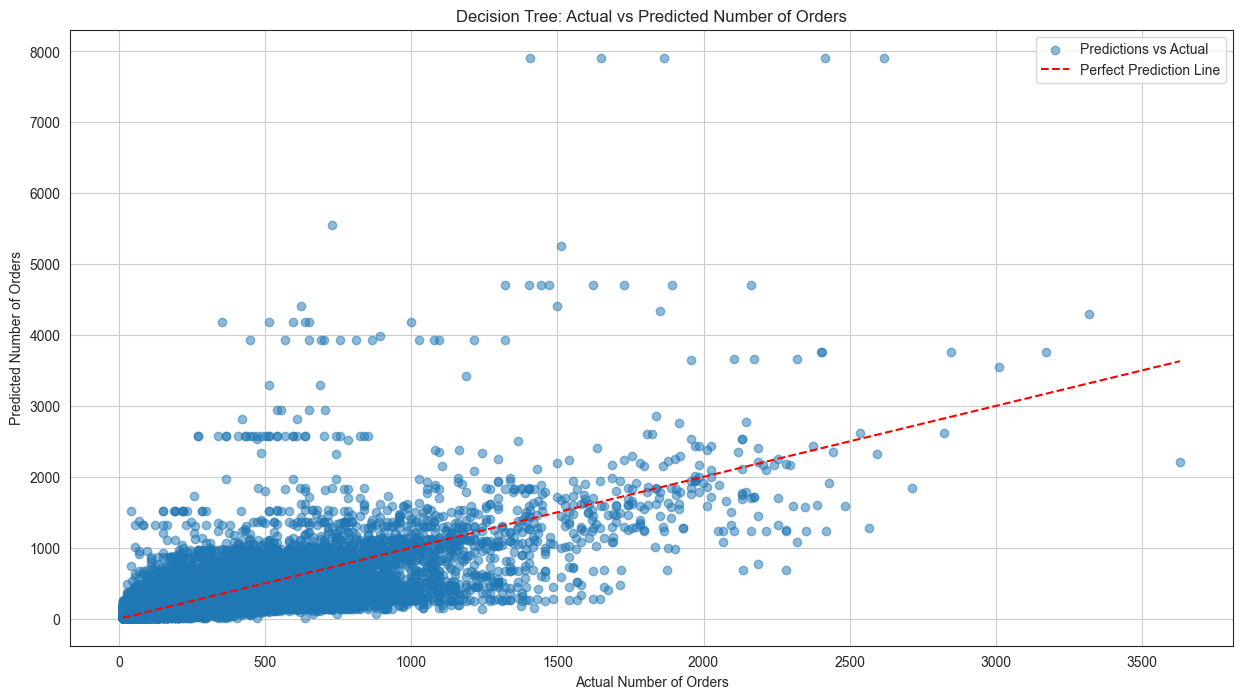

In [ ]:
# Plotting Decision Tree predictions vs Actual values
plt.figure(figsize=(15, 8))
plt.scatter(y_test, dtree_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Decision Tree: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 4: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(n_estimators=250,max_depth=17,max_features=None,oob_score=True)

In [ ]:
rfr.fit(X_train_transformed, y_train)

RandomForestRegressor(max_depth=17, max_features=None, n_estimators=250,
                      oob_score=True)

In [ ]:
rfr_predictions = rfr.predict(X_test_transformed)

In [ ]:
y_test

0         918
1         703
2         513
3         824
4        1014
         ... 
32816     161
32817      95
32818     123
32819     136
32820     135
Name: num_orders, Length: 32821, dtype: int64

In [ ]:
rfr_predictions

array([896.15, 712.75, 676.31, ..., 122.53, 146.52,  98.44])

In [ ]:
mae = metrics.mean_absolute_error(y_test,rfr_predictions)
mse = metrics.mean_squared_error(y_test, rfr_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, rfr_predictions))
r2 = metrics.r2_score(y_test, rfr_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, rfr_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)
print('Mape:', mape)

Mae: 67.23039391934975
Mse: 16226.50122755495
Rmse:  127.38328472588132
R2: 0.787900130710287
Mape: 0.5504109853674848


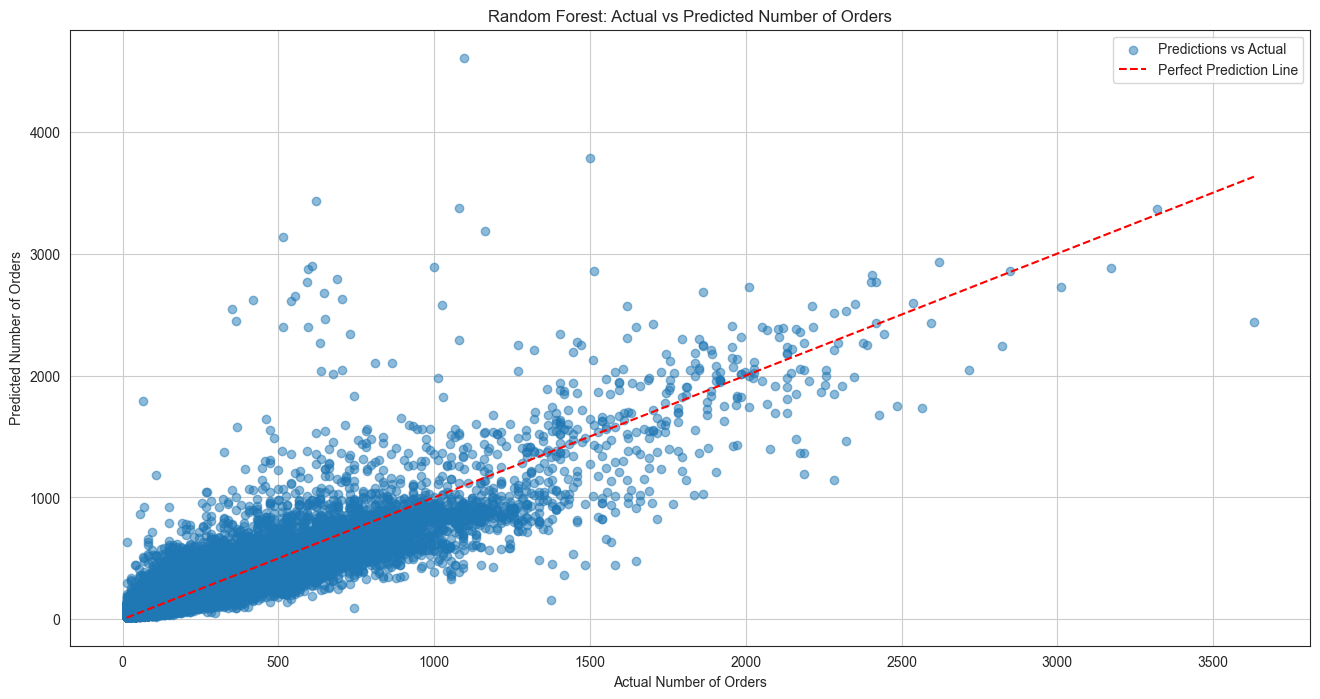

In [ ]:
# Plotting Random Forest predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test, rfr_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Random Forest: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 5: XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
xgb_regressor = xgb.XGBRegressor()

In [ ]:
xgb_regressor.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
xgb_predictions = xgb_regressor.predict(X_test_transformed)

In [ ]:
y_test

0         918
1         703
2         513
3         824
4        1014
         ... 
32816     161
32817      95
32818     123
32819     136
32820     135
Name: num_orders, Length: 32821, dtype: int64

In [ ]:
xgb_predictions

array([857.7639  , 582.099   , 664.34076 , ..., 118.150665, 126.06983 ,
       104.87175 ], dtype=float32)

In [ ]:
mse = metrics.mean_squared_error(y_test, xgb_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, xgb_predictions))
r2 = metrics.r2_score(y_test, xgb_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, xgb_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)
print('Mape:', mape)

Mae: 69.34679625849303
Mse: 16560.19891411542
Rmse:  128.68643640304683
R2: 0.7835383415222168
Mape: 0.5418214604859276


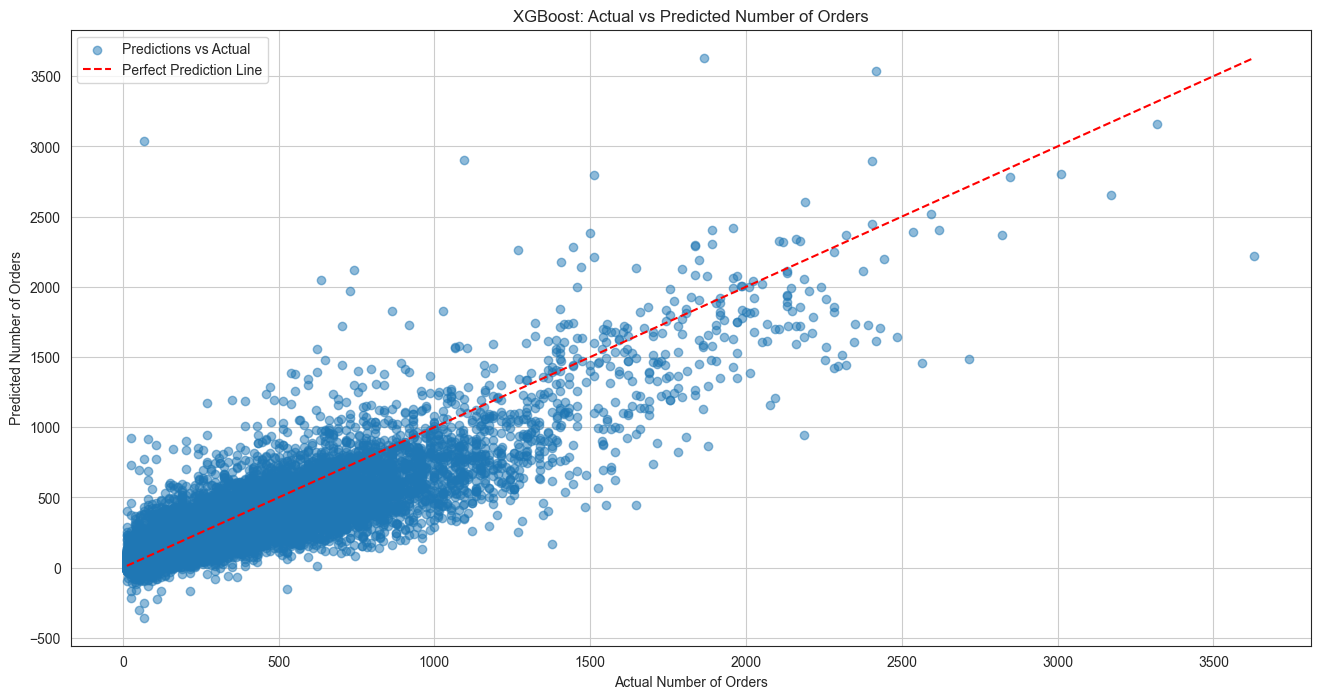

In [ ]:
# Plotting XGBoost predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test, xgb_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('XGBoost: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 6: light GBM

In [ ]:
import lightgbm as lgb

In [ ]:
lgb_regressor = lgb.LGBMRegressor(objective ='regression',metric = "rmse",n_estimators=100,random_state=42)

In [ ]:
lgb_regressor.fit(X_train_transformed, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4004
[LightGBM] [Info] Number of data points in the train set: 423727, number of used features: 52
[LightGBM] [Info] Start training from score 264.550536


LGBMRegressor(metric='rmse', objective='regression', random_state=42)

In [ ]:
lgb_predictions = lgb_regressor.predict(X_test_transformed)

In [ ]:
mse = metrics.mean_squared_error(y_test, lgb_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, lgb_predictions))
r2 = metrics.r2_score(y_test, lgb_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, lgb_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)
print('Mape:', mape)

Mae: 107.69525608604248
Mse: 17650.31210541735
Rmse:  132.85447717490499
R2: 0.7692892116432077
Mape: 0.5722315081995655


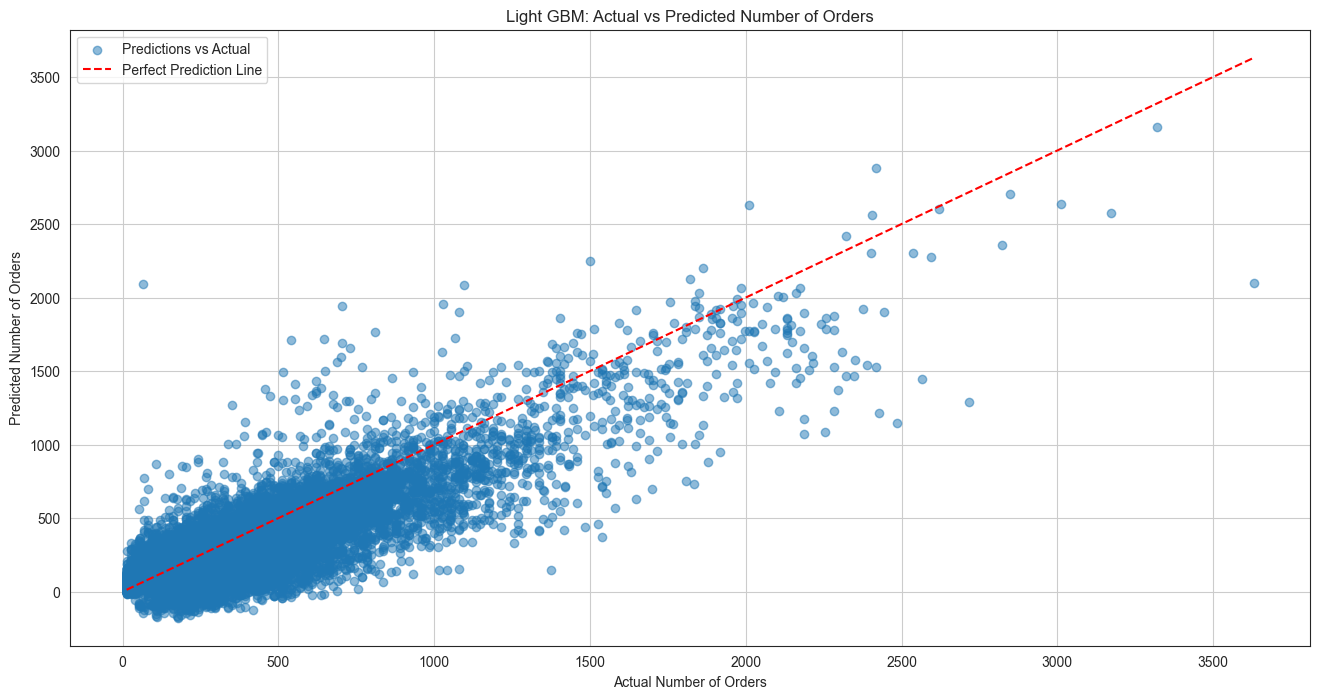

In [ ]:
# Plotting XGBoost predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test, lgb_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Light GBM: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# model 7: Cat boost

In [ ]:
import catboost as cb

In [ ]:
cb_regressor = cb.CatBoostRegressor(iterations=100,learning_rate=0.1,depth=6,loss_function='RMSE')

In [ ]:
cb_regressor.fit(X_train_transformed, y_train)

0:	learn: 379.7167388	total: 181ms	remaining: 17.9s
1:	learn: 358.7534081	total: 206ms	remaining: 10.1s
2:	learn: 340.1682950	total: 236ms	remaining: 7.64s
3:	learn: 322.6322875	total: 266ms	remaining: 6.38s
4:	learn: 307.5961643	total: 294ms	remaining: 5.58s
5:	learn: 294.1294143	total: 322ms	remaining: 5.05s
6:	learn: 282.2338027	total: 350ms	remaining: 4.65s
7:	learn: 271.9195514	total: 379ms	remaining: 4.36s
8:	learn: 262.5327862	total: 408ms	remaining: 4.13s
9:	learn: 254.1229163	total: 437ms	remaining: 3.93s
10:	learn: 246.8044029	total: 472ms	remaining: 3.82s
11:	learn: 240.2486740	total: 502ms	remaining: 3.68s
12:	learn: 233.9936142	total: 533ms	remaining: 3.56s
13:	learn: 228.5819551	total: 564ms	remaining: 3.46s
14:	learn: 223.9826447	total: 592ms	remaining: 3.35s
15:	learn: 219.9425724	total: 620ms	remaining: 3.26s
16:	learn: 216.3217468	total: 650ms	remaining: 3.17s
17:	learn: 213.1965904	total: 677ms	remaining: 3.08s
18:	learn: 210.3194993	total: 707ms	remaining: 3.01s
19:

In [ ]:
cb_predictions = cb_regressor.predict(X_test_transformed)

In [ ]:
mse = metrics.mean_squared_error(y_test, cb_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, cb_predictions))
r2 = metrics.r2_score(y_test, cb_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, cb_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)
print('Mape:', mape)

Mae: 107.69525608604248
Mse: 12918.740285776576
Rmse:  113.66063648324592
R2: 0.8311365409230711
Mape: 0.5617418780644815


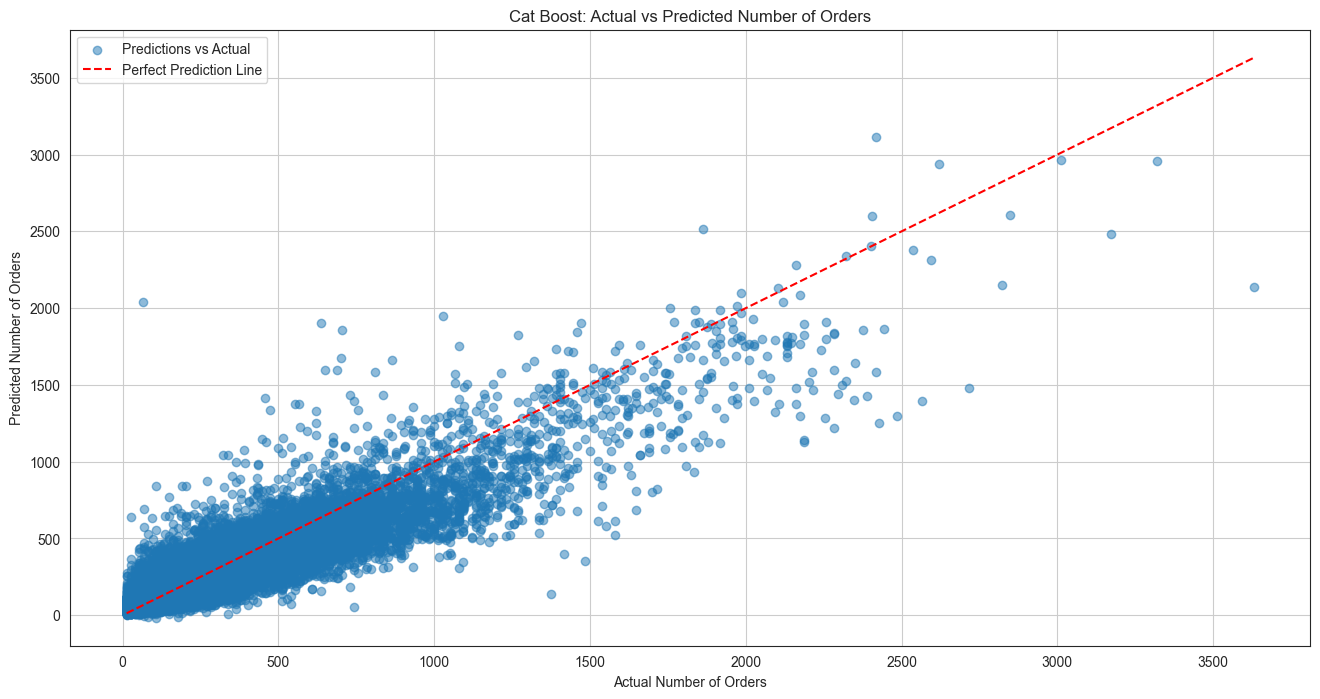

In [ ]:
# Plotting XGBoost predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test, cb_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Cat Boost: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

Since randon forest regressor gave the best result i.e low Rmse and high R sqaure value. Hence, randon forest regressor will be used to make submision for the Analytics Vidhya Food DEmand Prediction hackathon.

In [ ]:
last_10week_df_transformed = preprocessor.transform(last_10week_df.drop(columns=['num_orders'], axis=1).reset_index(drop=True))

In [ ]:
last_10week_predictions_rfr = rfr.predict(last_10week_df.drop(['num_orders', 'id'], axis=1).reset_index(drop=True))

In [ ]:
last_10week_df_transformed = preprocessor.transform(last_10week_df.drop(['num_orders', 'id'], axis=1).reset_index(drop=True))
last_10week_df_transformed

In [ ]:
last_10week_predictions_xgb = xgb_regressor.predict(last_10week_df_transformed)

In [ ]:
last_10week_predictions_xgb

In [ ]:
last_10week_predictions_rfr = rfr.predict(last_10week_df_transformed)
last_10week_predictions_rfr

array([884.09780485, 626.64112576, 433.23673261, ...,  41.87957232,
        40.53242408,  39.99167536])

In [ ]:
# Result=pd.DataFrame(last_10week_predictions_rfr)
# Result[Result<0] = 0 
# # Result=np.expm1(Result).astype('int64')
# Submission = pd.DataFrame(columns=['id', 'num_orders'])
# Submission['id'] = data[data['week'].isin(range(146,156))]['id']
# Submission['num_orders'] = Result.values
# Submission.to_csv('Result Random forest.csv', index=False)

# Testing feaatures

In [76]:
datay = data.copy()

In [77]:
datay['base_price_max'] = datay.groupby('meal_id')['base_price'].transform('max')
datay['base_price_min'] = datay.groupby('meal_id')['base_price'].transform('min')
datay['base_price_mean'] = round(datay.groupby('meal_id')['base_price'].transform('mean'),4)
datay['meal_price_max'] = datay.groupby('meal_id')['checkout_price'].transform('max')
datay['meal_price_min'] = datay.groupby('meal_id')['checkout_price'].transform('min')
datay['meal_price_mean'] = round(datay.groupby('meal_id')['checkout_price'].transform('mean'),4)
datay.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,lag_10,rolling_4_week_mean,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,0.0,0.00,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,0.0,865.00,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,0.0,823.50,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,0.0,832.67,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,0.0,925.00,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859


In [78]:
datay.groupby('meal_id')['base_price'].max()

meal_id
1062     195.03
1109     347.32
1198     340.53
1207     515.13
1216     641.23
1230     534.53
1247     505.43
1248     407.46
1311     340.53
1438     272.63
1445     866.27
1525     321.13
1543     602.43
1558     728.53
1571     680.03
1727     505.43
1754     376.42
1770     486.03
1778     195.03
1803     340.53
1847     272.63
1878     321.13
1885     179.51
1902     486.03
1962     728.53
1971     367.69
1993     165.93
2104     680.03
2126     581.03
2139     456.93
2290     330.83
2304     738.23
2306    1112.62
2322     515.13
2444     767.33
2490     354.11
2492     500.58
2494     272.63
2539     165.93
2569     363.81
2577     321.13
2581     728.53
2631     439.47
2640     321.13
2664     485.03
2704     321.13
2707     243.53
2760     262.93
2826     386.12
2867     767.33
2956     680.03
Name: base_price, dtype: float64

In [79]:
datay.isnull().sum()

id                              0
week                            0
center_id                       0
meal_id                         0
checkout_price                  0
base_price                      0
emailer_for_promotion           0
homepage_featured               0
num_orders                      0
city_code                       0
region_code                     0
center_type                     0
op_area                         0
category                        0
cuisine                         0
discount_amount                 0
discount_percent                0
discount y/n                    0
weekly_base_price_change        0
weekly_checkout_price_change    0
week_of_year                    0
quarter                         0
month                           0
4_week_avg_checkout_price       0
4_week_avg_base_price           0
lag_1                           0
lag_2                           0
lag_3                           0
lag_4                           0
lag_10        

In [80]:
datay.groupby(['category','center_id'])['num_orders'].count()

category   center_id
Beverages  10           1859
           11           1844
           13           1851
           14           1785
           17           1777
                        ... 
Starters   161           463
           162           282
           174           464
           177           367
           186           353
Name: num_orders, Length: 985, dtype: int64

In [81]:
datay['center_cat_count'] = datay.groupby(['category','center_id'])['num_orders'].transform('count')
datay.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,lag_10,rolling_4_week_mean,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,0.0,0.00,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,0.0,865.00,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,0.0,823.50,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,0.0,832.67,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,0.0,925.00,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859


In [90]:
# center_cat_price 
datay['center_cat_price_rank'] = datay.groupby(['category','center_id','meal_id'])['base_price'].rank(method='max').astype('int64')
datay.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,rolling_4_week_mean,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count,center_cat_price_rank
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,0.00,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,865.00,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,823.50,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,832.67,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,87
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,925.00,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39


In [ ]:
# center_cat_week_count:a count of orders belonging to a particular category in a particular center in a week. 
datay['center_cat_week_count'] = datay.groupby(['category','center_id','week'])['num_orders']. transform('count')
datay.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count,center_cat_price_rank,center_cat_week_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39,12
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60,12
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60,12
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,87,12
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39,12


In [97]:
# center_cui_count
datay['center_cui_count'] = datay.groupby(['cuisine','center_id'])['num_orders']. transform('count')
datay.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count,center_cat_price_rank,center_cat_week_count,center_cui_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39,12,1791
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60,12,1791
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60,12,1791
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,87,12,1791
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39,12,1791


In [112]:
# center_price_rank
datay['center_price_rank'] = datay.groupby(['meal_id','center_id'])['base_price'].rank(method='dense').astype('int64')

In [101]:
# center_week_order_count
datay['center_week_order_count'] = datay.groupby(['center_id','week'])['num_orders']. transform('count')

In [115]:
datay.groupby(['meal_id','center_id','week'])['base_price'].rank(method='dense').astype('int64').value_counts()

base_price
1    489121
Name: count, dtype: int64

In [103]:
# center_week_price_rank
datay['center_week_price_rank'] = datay.groupby(['center_id','week','meal_id'])['base_price']. rank(method='max').astype('int64')
datay['center_week_price_rank'].value_counts()

center_week_price_rank
1    489121
Name: count, dtype: int64

In [84]:
datay[datay['center_id'] == 10]

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,rolling_4_week_mean,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count,center_cat_price_rank
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,0.00,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39.0
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,865.00,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60.0
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,823.50,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60.0
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,832.67,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,87.0
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,925.00,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475622,1224017,151,10,2956,581.03,583.03,0,0,0,590,...,0.00,-25.42,680.03,435.53,599.1329,680.03,292.03,583.8671,228,49.0
478849,1456472,152,10,2956,581.03,581.03,0,0,0,590,...,0.00,-26.74,680.03,435.53,599.1329,680.03,292.03,583.8671,228,17.0
482108,1387675,153,10,2956,581.03,583.03,0,0,0,590,...,0.00,-30.82,680.03,435.53,599.1329,680.03,292.03,583.8671,228,49.0
485354,1043351,154,10,2956,680.03,680.03,0,0,0,590,...,0.00,1.64,680.03,435.53,599.1329,680.03,292.03,583.8671,228,92.0


In [86]:
datay.isnull().sum()

id                              0
week                            0
center_id                       0
meal_id                         0
checkout_price                  0
base_price                      0
emailer_for_promotion           0
homepage_featured               0
num_orders                      0
city_code                       0
region_code                     0
center_type                     0
op_area                         0
category                        0
cuisine                         0
discount_amount                 0
discount_percent                0
discount y/n                    0
weekly_base_price_change        0
weekly_checkout_price_change    0
week_of_year                    0
quarter                         0
month                           0
4_week_avg_checkout_price       0
4_week_avg_base_price           0
lag_1                           0
lag_2                           0
lag_3                           0
lag_4                           0
lag_10        

In [ ]:
# datay['center_cat_price_rank'] = datay['center_cat_price_rank'].astype('int64')
# datay

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,rolling_4_week_mean,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count,center_cat_price_rank
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,0.00,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,865.00,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,823.50,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,832.67,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,87
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,925.00,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345410,1255251,112,186,2956,583.03,581.03,0,0,82,649,...,51.50,-2.03,680.03,435.53,599.1329,680.03,292.03,583.8671,204,10
348601,1436164,113,186,2956,583.03,582.03,0,0,40,649,...,58.25,-0.80,680.03,435.53,599.1329,680.03,292.03,583.8671,204,19
351905,1000576,114,186,2956,583.03,581.03,0,0,27,649,...,57.75,-1.44,680.03,435.53,599.1329,680.03,292.03,583.8671,204,10
355206,1429037,115,186,2956,581.03,583.03,0,0,15,649,...,51.00,0.02,680.03,435.53,599.1329,680.03,292.03,583.8671,204,30
